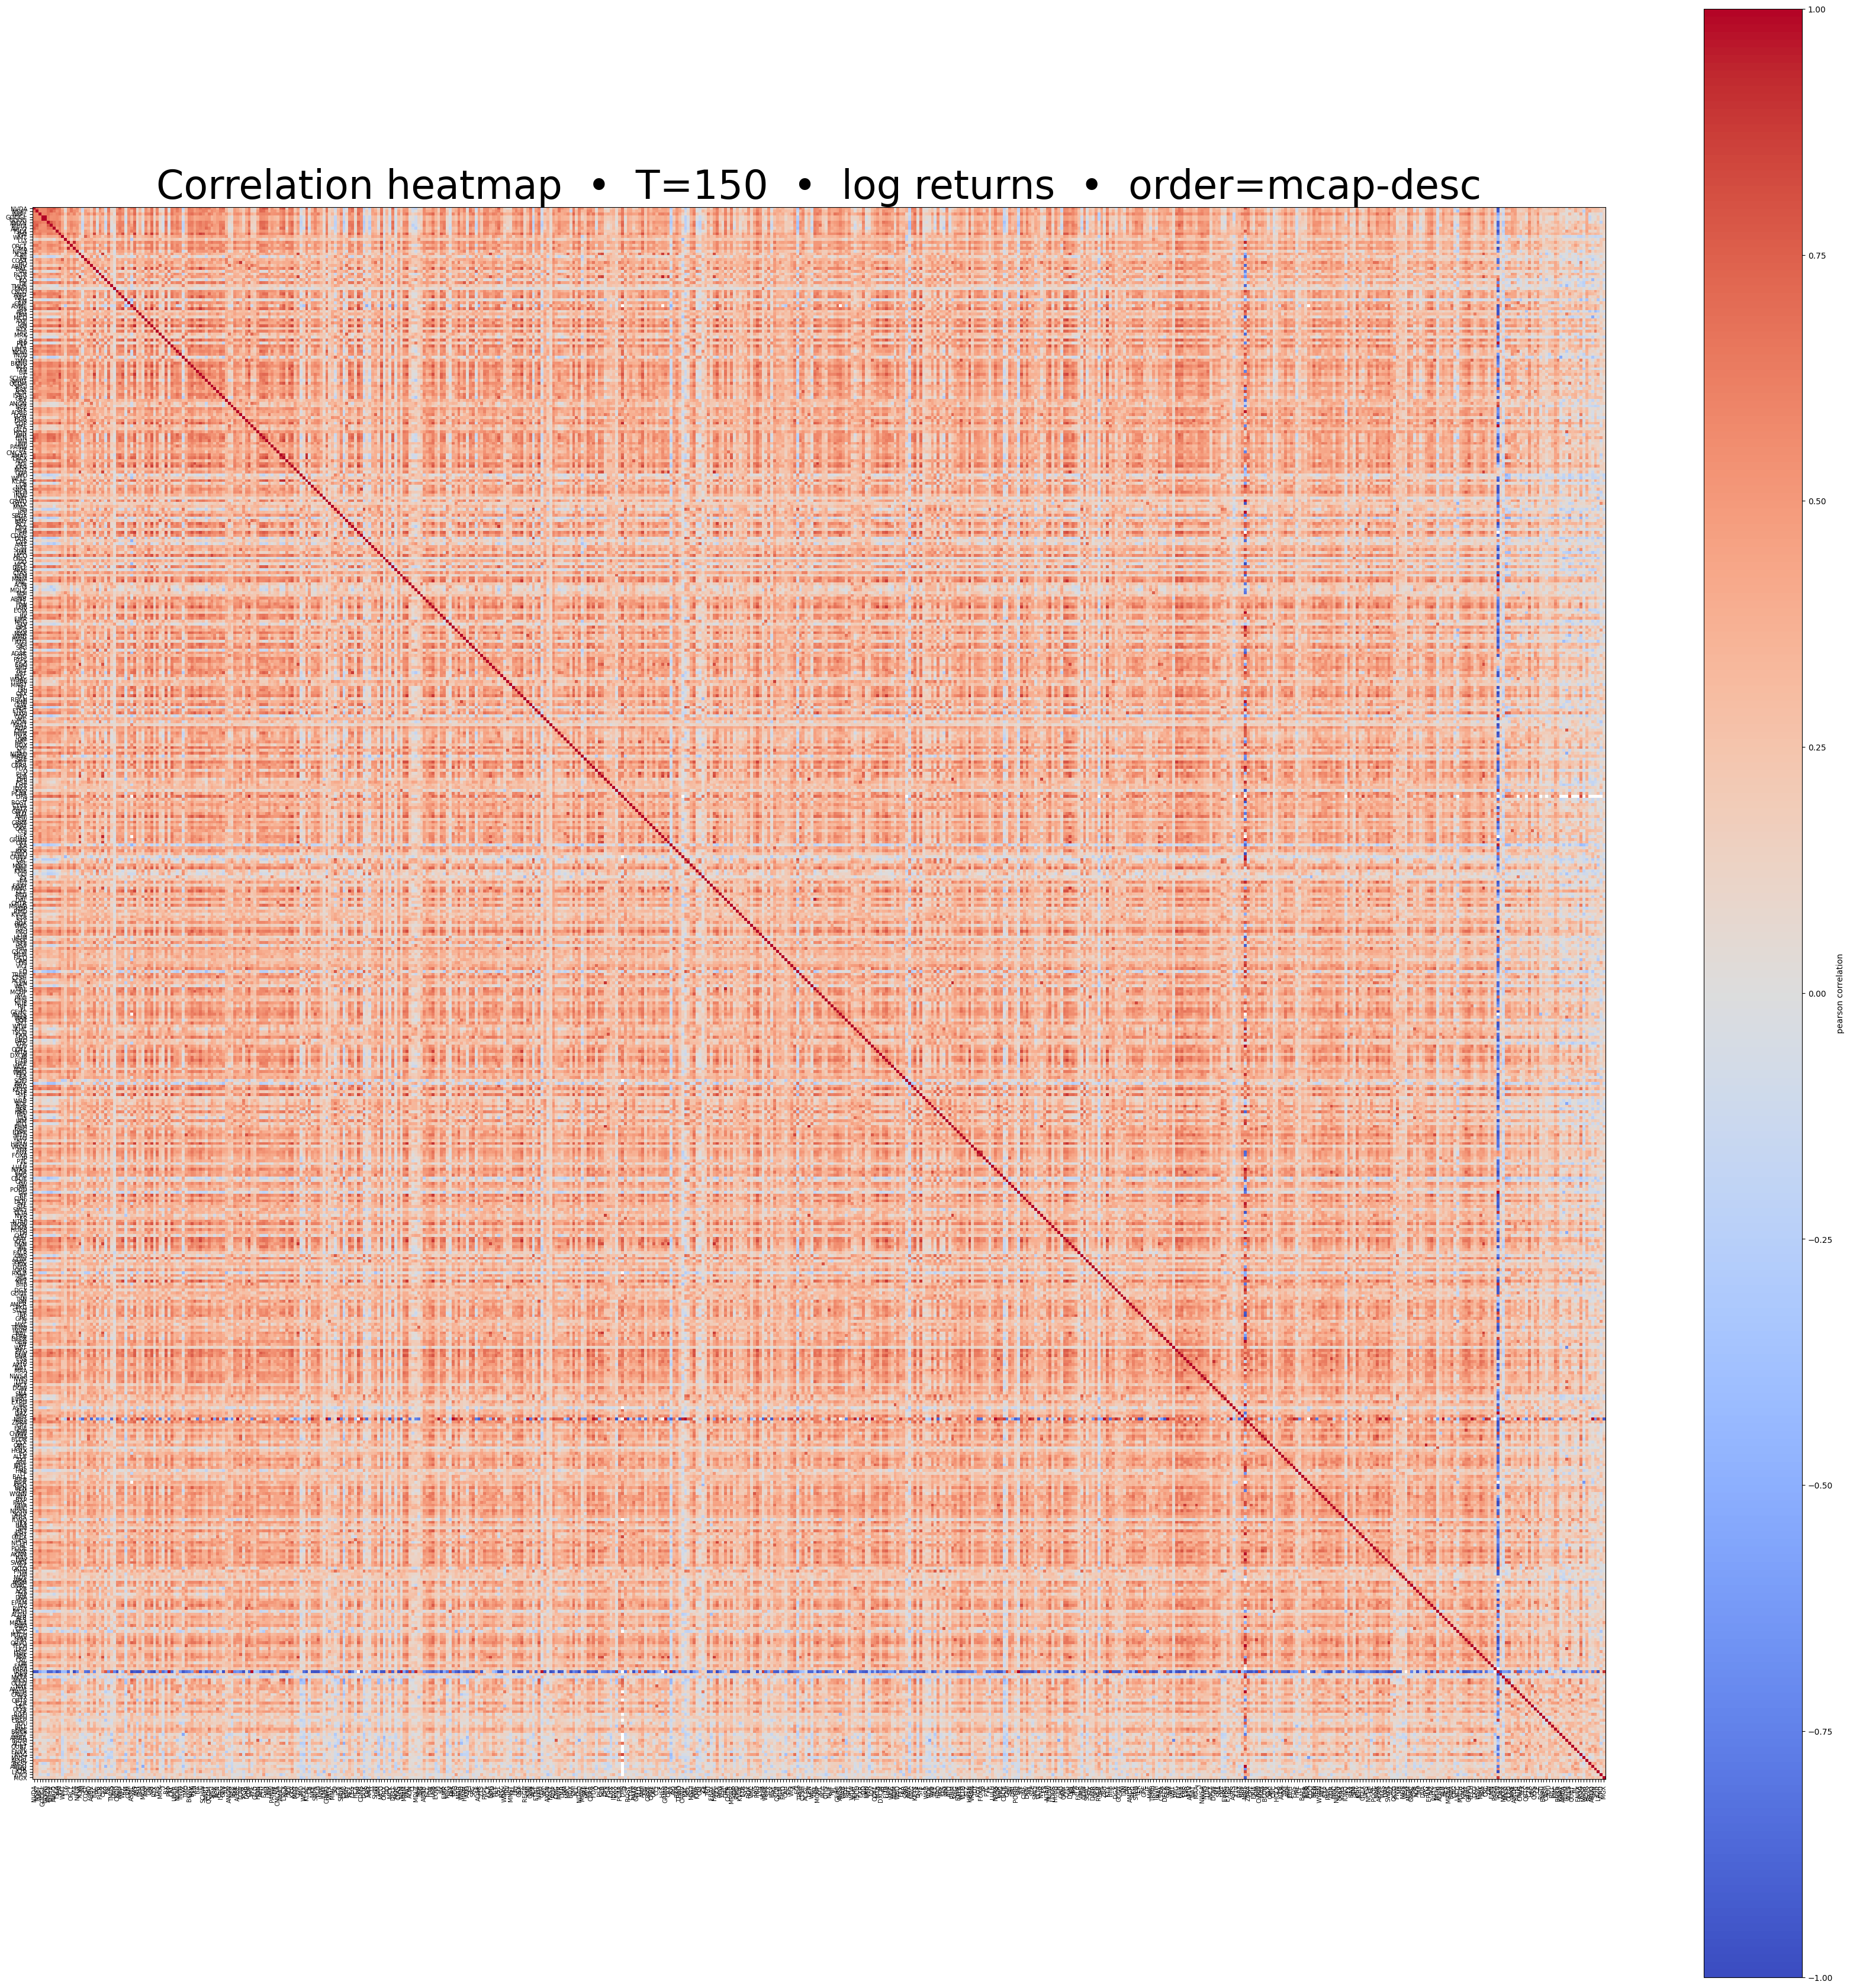

[('FFIV', 'IREN', np.float64(-0.9999022620447113)),
 ('GEHC', 'IREN', np.float64(-0.9997294374356592)),
 ('IPG', 'IREN', np.float64(-0.9991218479470695)),
 ('ARE', 'IREN', np.float64(-0.9990461774411519)),
 ('BEN', 'IREN', np.float64(-0.9982120262624723)),
 ('IREN', 'LRCX', np.float64(-0.9967458855931957)),
 ('IREN', 'K', np.float64(-0.9958090665371744)),
 ('IREN', 'MA', np.float64(-0.9945289519839179)),
 ('IREN', 'LAZR', np.float64(-0.9938975336438826)),
 ('IREN', 'IRM', np.float64(-0.9883613698448995))]

In [1]:
# %% Correlation heatmap from your CSV (semicolon ";") + ordering options
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# === 0) SETTINGS ===
CSV_PATH = "/Users/michal/Downloads/stocks_data-2.csv"  # <-- replace with your file
T = 150                            # window of number of sessions for correlation
RET_KIND = "log"                   # "pct" (percentage) | "log" (log-returns)
CORR_KIND = "pearson"              # "pearson" | "spearman" | "kendall" | "sign"
ORDER_MODE = "mcap-desc"           # "original" | "mean-corr" | "spectral" | "hierarchical" | "mcap-desc" | "mcap-asc"
PORTFOLIO_TICKERS = None           # e.g. ["AAPL","MSFT","NVDA"] or None = all in file

def to_float(s):
    if pd.isna(s): return np.nan
    s = str(s).replace("\u00A0"," ").strip()
    s = s.replace(",", "")
    s = "".join(ch for ch in s if ch.isdigit() or ch in ".-")
    try:
        return float(s) if s not in {"",".","-"} else np.nan
    except:
        return np.nan

def parse_market_cap_with_suffix(x):
    """Parses '3.66T', '24.1B', '180M', '900K' -> float USD."""
    if pd.isna(x): 
        return np.nan
    s = str(x).strip().upper().replace(",", "")
    mult = 1.0
    if s.endswith("T"):
        mult, s = 1e12, s[:-1]
    elif s.endswith("B"):
        mult, s = 1e9, s[:-1]
    elif s.endswith("M"):
        mult, s = 1e6, s[:-1]
    elif s.endswith("K"):
        mult, s = 1e3, s[:-1]
    try:
        return float(s) * mult
    except:
        return np.nan

# === 1) Load CSV and prepare wide-frame prices ===
df = pd.read_csv(CSV_PATH, sep=";", dtype=str, low_memory=False)

if "Date of record" not in df.columns or "Stock" not in df.columns:
    raise ValueError("File must contain columns 'Date of record' and 'Stock'.")

df["Date of record"] = pd.to_datetime(df["Date of record"], errors="coerce")
df["Stock"] = df["Stock"].str.upper().str.strip()

# — ticker exclusions (e.g. incorrect market cap for TSM)
EXCLUDE_TICKERS = {"TSM"}
df = df[~df["Stock"].isin(EXCLUDE_TICKERS)].copy()

price_col = "Closing Price" if "Closing Price" in df.columns else "Price"
if price_col not in df.columns:
    raise ValueError("No 'Closing Price' or 'Price' column — cannot compute returns.")
df[price_col] = df[price_col].apply(to_float)

core = (
    df[["Date of record", "Stock", price_col]]
    .dropna(subset=["Date of record","Stock"])
    .sort_values(["Stock","Date of record"])
    .groupby(["Date of record","Stock"], as_index=False).last()
)

P = core.pivot(index="Date of record", columns="Stock", values=price_col).sort_index()

if PORTFOLIO_TICKERS:
    keep = [t for t in PORTFOLIO_TICKERS if t in P.columns]
    if not keep:
        raise ValueError("None of the PORTFOLIO_TICKERS are present in the data.")
    P = P[keep]

P = P.tail(T+1)  # +1 because later we do .pct_change() or diff

# === 2) Returns ===
if RET_KIND == "pct":
    R = P.pct_change()
else:  # "log"
    R = np.log(P).diff()

# === 3) Correlation (pairwise complete) ===
def signify(x: pd.DataFrame) -> pd.DataFrame:
    s = np.sign(x)
    return pd.DataFrame(s, index=x.index, columns=x.columns)

if CORR_KIND == "sign":
    X = signify(R)
    corr = X.corr(method="pearson", min_periods=3)
else:
    corr = R.corr(method=CORR_KIND, min_periods=3)

tickers = corr.columns.tolist()
C = corr.values.copy()
np.fill_diagonal(C, 1.0)
C = np.clip(C, -1, 1)

# === 3b) Market caps (latest available) for sorting by capitalization ===
mcap_series = None
if ORDER_MODE in ("mcap-desc", "mcap-asc"):
    if "Market cap clear" in df.columns:
        tmp = (
            df[["Stock", "Date of record", "Market cap clear"]]
            .dropna(subset=["Stock"])
            .copy()
        )
        tmp["Market cap clear"] = tmp["Market cap clear"].apply(to_float)
        tmp["Stock"] = tmp["Stock"].str.upper().str.strip()
        tmp = tmp.sort_values(["Stock", "Date of record"]).groupby("Stock", as_index=False).last()
        mc = pd.Series(tmp["Market cap clear"].values, index=tmp["Stock"])
    elif "Market cap" in df.columns:
        tmp = (
            df[["Stock", "Date of record", "Market cap"]]
            .dropna(subset=["Stock"])
            .copy()
        )
        tmp["Market cap"] = tmp["Market cap"].apply(parse_market_cap_with_suffix)
        tmp["Stock"] = tmp["Stock"].str.upper().str.strip()
        tmp = tmp.sort_values(["Stock", "Date of record"]).groupby("Stock", as_index=False).last()
        mc = pd.Series(tmp["Market cap"].values, index=tmp["Stock"])
    else:
        mc = pd.Series(dtype=float)

    # reindex to TICKERS that actually made it to the correlation matrix
    mcap_series = mc.reindex(tickers)

# === 4) Ordering sequence (like in streamlit) ===
def order_indices(C: np.ndarray, mode: str) -> np.ndarray:
    n = C.shape[0]
    if mode == "original":
        return np.arange(n)
    if mode == "mean-corr":
        mean_c = np.nanmean(C, axis=1)
        return np.argsort(-mean_c)
    if mode == "spectral":
        A = np.nan_to_num((C + 1.0) / 2.0, nan=0.0)   # [0,1]
        np.fill_diagonal(A, 0.0)
        d = A.sum(axis=1)
        L = np.diag(d) - A
        w, V = np.linalg.eigh(L)
        if len(w) >= 2:
            fiedler = V[:, 1]
            return np.argsort(fiedler)
        return np.arange(n)
    if mode == "hierarchical":
        try:
            from scipy.spatial.distance import squareform
            from scipy.cluster.hierarchy import linkage, leaves_list
            D = np.sqrt(np.maximum(0.0, 2*(1 - np.clip(C, -1, 1))))
            dc = squareform(D, checks=False)
            Z = linkage(dc, method="average")
            leaves = leaves_list(Z)
            return leaves
        except Exception:
            return order_indices(C, "spectral")
    return np.arange(n)

# choose order
if ORDER_MODE in ("mcap-desc", "mcap-asc") and mcap_series is not None and len(mcap_series):
    arr = mcap_series.values.astype(float)
    idx = np.arange(len(arr))
    valid = np.isfinite(arr)
    if ORDER_MODE == "mcap-desc":
        primary = idx[valid][np.argsort(-arr[valid])]
    else:
        primary = idx[valid][np.argsort(arr[valid])]
    rest = idx[~valid]
    order = np.concatenate([primary, rest])
else:
    order = order_indices(C, ORDER_MODE)

# apply order always AFTER building 'order'
C_ord = C[np.ix_(order, order)]
ticks_ord = [tickers[i] for i in order]

# === 5) Heatmap + save ===
n = len(ticks_ord)
fig, ax = plt.subplots(figsize=(max(6, 0.35*n), max(5, 0.35*n)))
im = ax.imshow(C_ord, cmap="coolwarm", vmin=-1, vmax=1, aspect="equal", interpolation="nearest")
fig.colorbar(im, ax=ax, label=f"{CORR_KIND} correlation")

ax.set_xticks(range(n))
ax.set_xticklabels(ticks_ord, rotation=90, fontsize=7)
ax.set_yticks(range(n))
ax.set_yticklabels(ticks_ord, fontsize=7)
ax.set_title(f"Correlation heatmap  •  T={T}  •  {RET_KIND} returns  •  order={ORDER_MODE}", fontsize=48)
fig.tight_layout()

# --- SAVE JPG with hard pixel cap (max 10000 x 10000) ---
out_path = "/Users/michal/Downloads/corr map stocks/correlation_heatmap.jpg"
max_px = 10000       # <- if you want 20000, change here
dpi = 300

w_px = fig.get_figwidth() * dpi
h_px = fig.get_figheight() * dpi
scale = min(1.0, max_px / max(w_px, h_px))
fig.set_size_inches(fig.get_figwidth() * scale, fig.get_figheight() * scale)

try:
    fig.savefig(
        out_path, dpi=dpi, format="jpg", bbox_inches="tight",
        pil_kwargs={"quality": 95, "optimize": True, "progressive": True}
    )
except TypeError:
    fig.savefig(out_path, dpi=dpi, format="jpg", bbox_inches="tight")

plt.show()
# plt.close(fig)

# === 6) Top 20 most negative pairs ===
pairs = []
for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        pairs.append((tickers[i], tickers[j], C[i, j]))
top_neg = sorted(pairs, key=lambda x: x[2])[:20]
top_neg[:10]